In [217]:
# Base Libraries
import time
import datetime
import os
import re

# Scientific libraries
import pandas as pd
import numpy as np
from pandas.core.interchange.dataframe_protocol import DataFrame
from scipy.stats import alpha
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visual libraries
import seaborn as sns
from seaborn import objects as so
import matplotlib.pyplot as plt
from sklearn.utils.estimator_checks import estimator_checks_generator

print("Set up complete")

Set up complete


# 1. Data Preparation

In [12]:
procDataPath = "C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/processed_AllFishCombined_unfiltered.csv"
#
# procAnaPath = "C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/processed_AnalysisData.csv"

proc_data = pd.read_csv(procDataPath, parse_dates=True)

# proc_ana = pd.read_csv(procAnaPath, parse_dates=True)
print("Reading complete")

C:\Users\86139\AppData\Local\Temp\ipykernel_20264\1865859149.py:5: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  proc_data = pd.read_csv(procDataPath, parse_dates=True)


Reading complete


In [2]:
## Subset EDA, Training, and Validation data
burbotCount = 2
lakeTroutCount = 17
lakeWhiteFishCount = 10
smallMouthBassCount = 12

## Predixes
burbotPr = "BUR"
lakeTroutPr = "LT"
lakeWhiteFishPr = "LWF"
smallMouthBassPr = "SMB"


## Generate the fishNum
def makeFishNum(prefix, count):
    """
    Computes an array of fish numbers, in format like "LWF001", "LWF012"
    :param prefix: a string of character in length 2 or 3, all capitalized
    :param count: an integer
    :return: a list of strings that represent fish numbers, count from 001 to 00n
    """
    countSeq = list(range(count+1))[1:]
    fishNum = [prefix + (3-len(str(c)))*"0" + str(c) for c in countSeq]
    return fishNum
burbotNum = makeFishNum("BUR", burbotCount)
lakeTroutNum = makeFishNum("LT", lakeTroutCount)
lakeWhiteFishNum = makeFishNum("LWF", lakeWhiteFishCount)
smallMouthBassNum = makeFishNum("SMB", smallMouthBassCount)

In [50]:
# Subset desired rows from original datasets as dataset for EDA
edaFishNum = burbotNum + lakeTroutNum + lakeWhiteFishNum + smallMouthBassNum
edaData = proc_data.loc[proc_data.fishNum.isin(edaFishNum),]

# The rest will be held out as test set
testData = proc_data.loc[~proc_data.fishNum.isin(edaFishNum),]

In [16]:
## Save the training and Test Set to csv
edaData.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/edaData.csv")
testData.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/testData.csv")

In [32]:
physicalVar = ["species", "sex", "totalLength", "forkLength", "weight", "girth", "dorsoLatHeight", "mat", "airbladderTotalLength", "airBladderWidth", "airbladderWeight", "airBladderWeightCond"]
edaPhy = edaData[["fishNum"] + physicalVar]

edaPhyDtype = edaPhy.dtypes
edaNaCount = edaPhy.isnull().sum()
pd.DataFrame({"Type": edaPhyDtype, "Missing-Count": edaNaCount})

,Type,Missing-Count
fishNum,object,0
species,object,0
totalLength,int64,0
forkLength,float64,288
weight,int64,0
girth,int64,0
dorsoLatHeight,int64,0
sex,object,0
mat,int64,0
airbladderTotalLength,int64,0


In [38]:
allFreq = [col for col in proc_data.columns if re.match(r'^F\d+', col)]
edaFreq = edaData[["fishNum"] + allFreq]
edaFreqSmry = edaFreq.groupby("fishNum").apply(lambda x: x.isnull().sum())
edaFreqSmry.head()

C:\Users\86139\AppData\Local\Temp\ipykernel_20264\2343574041.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  edaFreqSmry = edaFreq.groupby("fishNum").apply(lambda x: x.isnull().sum())


,fishNum,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BUR002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LT001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LT002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LT003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
sns.heatmap(edaFreqSmry[1:], annot=True,  cbar = False, cmap = 'tab20c_r')
plt.title("Missing Frequencies Heatmap")
plt.show()

KeyError: "'blue' is not a known colormap name"

In [37]:
# [var in edaData.columns.tolist() for var in physicalVar]
# edaData.columns.tolist()
edaData.loc[edaData["airbladderWeight"].isnull(), "fishNum"].unique()

array(['BUR001', 'BUR002', 'LWF003'], dtype=object)

# 2. Data Wrangling

In [129]:
## Renaming airBladder variables
edaPhy.rename({"airbladderTotalLength":"abLen", "airBladderWidth":"abWidth", "airbladderWeight":"abWeight", "airBladderWeightCond":"abWeightCond"}, axis=1, inplace=True)
edaPhy.columns

Index(['fishNum', 'species', 'totalLength', 'forkLength', 'weight', 'girth',
       'dorsoLatHeight', 'sex', 'mat', 'abLen', 'abWidth', 'abWeight',
       'abWeightCond'],
      dtype='object')

In [143]:
edaFreqSmry = edaFreq.groupby("fishNum").mean()
edaFreqSmry.head()

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,-46.479146,-46.629557,-46.066176,-45.091633,-44.798135,-44.437357,-44.456649,-44.437115,-44.456290,-44.717498,...,-29.060127,-28.443539,-27.567882,-26.713292,-25.613016,-24.387497,-23.621642,-22.306471,-21.985734,-21.591365
BUR002,-51.093437,-51.122888,-51.061878,-50.517705,-50.253662,-49.785299,-49.516891,-49.249549,-49.433040,-49.961681,...,-34.172427,-32.880550,-31.683651,-30.946173,-30.176796,-29.134342,-28.314172,-27.109958,-26.599481,-26.088878
LT001,-46.645407,-46.367350,-46.199488,-45.653350,-45.463655,-45.166661,-45.074204,-44.997179,-44.868336,-44.747247,...,-33.118848,-32.515203,-32.140573,-31.557621,-30.972239,-30.231923,-29.673079,-29.033348,-28.952772,-28.955729
LT002,-47.560521,-47.215797,-46.932365,-46.473483,-46.410474,-46.206567,-46.141046,-46.063951,-45.928372,-45.810265,...,-37.753181,-37.507503,-37.102629,-36.608307,-36.339585,-35.996327,-36.046391,-35.933225,-36.000538,-35.998340
LT003,-46.168306,-45.968098,-45.782728,-45.344954,-45.274179,-45.040486,-44.923072,-44.748890,-44.548537,-44.354827,...,-33.244680,-32.686375,-32.061705,-31.470881,-30.837042,-30.222146,-29.694168,-28.856576,-28.702194,-28.481229


In [145]:
## Drop NAs in accoustic data
## Remove LT008
edaFreqSmry.drop("LT008", axis=0, inplace = True)
# Remove all columns with any missing values
edaFreqSmry.dropna(axis=1, how="any", inplace=True)
edaFreqSmry

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,-46.479146,-46.629557,-46.066176,-45.091633,-44.798135,-44.437357,-44.456649,-44.437115,-44.456290,-44.717498,...,-29.060127,-28.443539,-27.567882,-26.713292,-25.613016,-24.387497,-23.621642,-22.306471,-21.985734,-21.591365
BUR002,-51.093437,-51.122888,-51.061878,-50.517705,-50.253662,-49.785299,-49.516891,-49.249549,-49.433040,-49.961681,...,-34.172427,-32.880550,-31.683651,-30.946173,-30.176796,-29.134342,-28.314172,-27.109958,-26.599481,-26.088878
LT001,-46.645407,-46.367350,-46.199488,-45.653350,-45.463655,-45.166661,-45.074204,-44.997179,-44.868336,-44.747247,...,-33.118848,-32.515203,-32.140573,-31.557621,-30.972239,-30.231923,-29.673079,-29.033348,-28.952772,-28.955729
LT002,-47.560521,-47.215797,-46.932365,-46.473483,-46.410474,-46.206567,-46.141046,-46.063951,-45.928372,-45.810265,...,-37.753181,-37.507503,-37.102629,-36.608307,-36.339585,-35.996327,-36.046391,-35.933225,-36.000538,-35.998340
LT003,-46.168306,-45.968098,-45.782728,-45.344954,-45.274179,-45.040486,-44.923072,-44.748890,-44.548537,-44.354827,...,-33.244680,-32.686375,-32.061705,-31.470881,-30.837042,-30.222146,-29.694168,-28.856576,-28.702194,-28.481229
LT004,-40.730473,-40.601601,-40.601523,-40.309100,-40.244519,-40.078168,-39.976723,-39.825742,-39.626494,-39.494479,...,-31.923855,-31.605860,-31.212022,-30.949060,-30.625302,-30.198328,-30.159049,-30.135791,-30.374540,-30.536444
LT005,-60.496846,-60.252259,-60.142293,-59.752711,-59.717030,-59.492988,-59.327611,-59.181236,-59.033960,-58.906425,...,-44.351424,-44.419923,-44.419437,-44.427077,-44.630374,-44.598437,-44.986819,-45.202528,-45.680993,-46.040943
LT006,-38.467984,-38.332608,-38.188313,-37.787999,-37.744940,-37.498326,-37.387439,-37.210920,-37.053602,-36.852407,...,-31.669777,-31.375899,-31.057959,-30.655594,-30.324443,-29.802385,-29.451981,-29.102356,-29.016297,-29.030183
LT007,-44.213031,-44.013071,-43.864818,-43.497515,-43.414356,-43.311410,-43.464125,-43.561277,-43.450102,-43.243596,...,-33.626353,-33.465612,-33.238753,-32.863688,-32.678450,-32.476953,-32.545077,-32.588351,-32.863067,-32.776063


In [156]:
edaFreqSmry['species'] = edaData[['fishNum', 'species']].groupby("fishNum").first()
edaFreqSmry

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260,species
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,-46.479146,-46.629557,-46.066176,-45.091633,-44.798135,-44.437357,-44.456649,-44.437115,-44.456290,-44.717498,...,-28.443539,-27.567882,-26.713292,-25.613016,-24.387497,-23.621642,-22.306471,-21.985734,-21.591365,burbot
BUR002,-51.093437,-51.122888,-51.061878,-50.517705,-50.253662,-49.785299,-49.516891,-49.249549,-49.433040,-49.961681,...,-32.880550,-31.683651,-30.946173,-30.176796,-29.134342,-28.314172,-27.109958,-26.599481,-26.088878,burbot
LT001,-46.645407,-46.367350,-46.199488,-45.653350,-45.463655,-45.166661,-45.074204,-44.997179,-44.868336,-44.747247,...,-32.515203,-32.140573,-31.557621,-30.972239,-30.231923,-29.673079,-29.033348,-28.952772,-28.955729,lakeTrout
LT002,-47.560521,-47.215797,-46.932365,-46.473483,-46.410474,-46.206567,-46.141046,-46.063951,-45.928372,-45.810265,...,-37.507503,-37.102629,-36.608307,-36.339585,-35.996327,-36.046391,-35.933225,-36.000538,-35.998340,lakeTrout
LT003,-46.168306,-45.968098,-45.782728,-45.344954,-45.274179,-45.040486,-44.923072,-44.748890,-44.548537,-44.354827,...,-32.686375,-32.061705,-31.470881,-30.837042,-30.222146,-29.694168,-28.856576,-28.702194,-28.481229,lakeTrout
LT004,-40.730473,-40.601601,-40.601523,-40.309100,-40.244519,-40.078168,-39.976723,-39.825742,-39.626494,-39.494479,...,-31.605860,-31.212022,-30.949060,-30.625302,-30.198328,-30.159049,-30.135791,-30.374540,-30.536444,lakeTrout
LT005,-60.496846,-60.252259,-60.142293,-59.752711,-59.717030,-59.492988,-59.327611,-59.181236,-59.033960,-58.906425,...,-44.419923,-44.419437,-44.427077,-44.630374,-44.598437,-44.986819,-45.202528,-45.680993,-46.040943,lakeTrout
LT006,-38.467984,-38.332608,-38.188313,-37.787999,-37.744940,-37.498326,-37.387439,-37.210920,-37.053602,-36.852407,...,-31.375899,-31.057959,-30.655594,-30.324443,-29.802385,-29.451981,-29.102356,-29.016297,-29.030183,lakeTrout
LT007,-44.213031,-44.013071,-43.864818,-43.497515,-43.414356,-43.311410,-43.464125,-43.561277,-43.450102,-43.243596,...,-33.465612,-33.238753,-32.863688,-32.678450,-32.476953,-32.545077,-32.588351,-32.863067,-32.776063,lakeTrout


# 3. Data Visualization

In [71]:
## First, we extract unique values from edaPhy
edaPhyUniq = edaPhy.groupby("fishNum").first().reset_index()

In [139]:
## Plot every Physical variables in a scatter by species, exclude fish with missing values
def catPhy(df, phyVar):
    # Create the histogram
    sns.catplot(df, x="species", y=phyVar,
                hue = "species",
                palette="bright",
                alpha=0.5,
                kind = "violin")
    plt.title(f"Violin Plot of {phyVar}, Colored by Species")
    plt.xticks(rotation=45)
    # plt.show()
    plt.savefig(f"C:/Users/86139/Desktop/Images/{phyVar}.png")

def multiCatPhy(df, phyVarArray):
    for phyVar in phyVarArray:
        catPhy(df, phyVar)
    return None
physicalVar = edaPhy.columns.tolist()[2:]
# catPhy(edaPhy, "abLen")
# multiCatPhy(edaPhyUniq, physicalVar)

C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should o

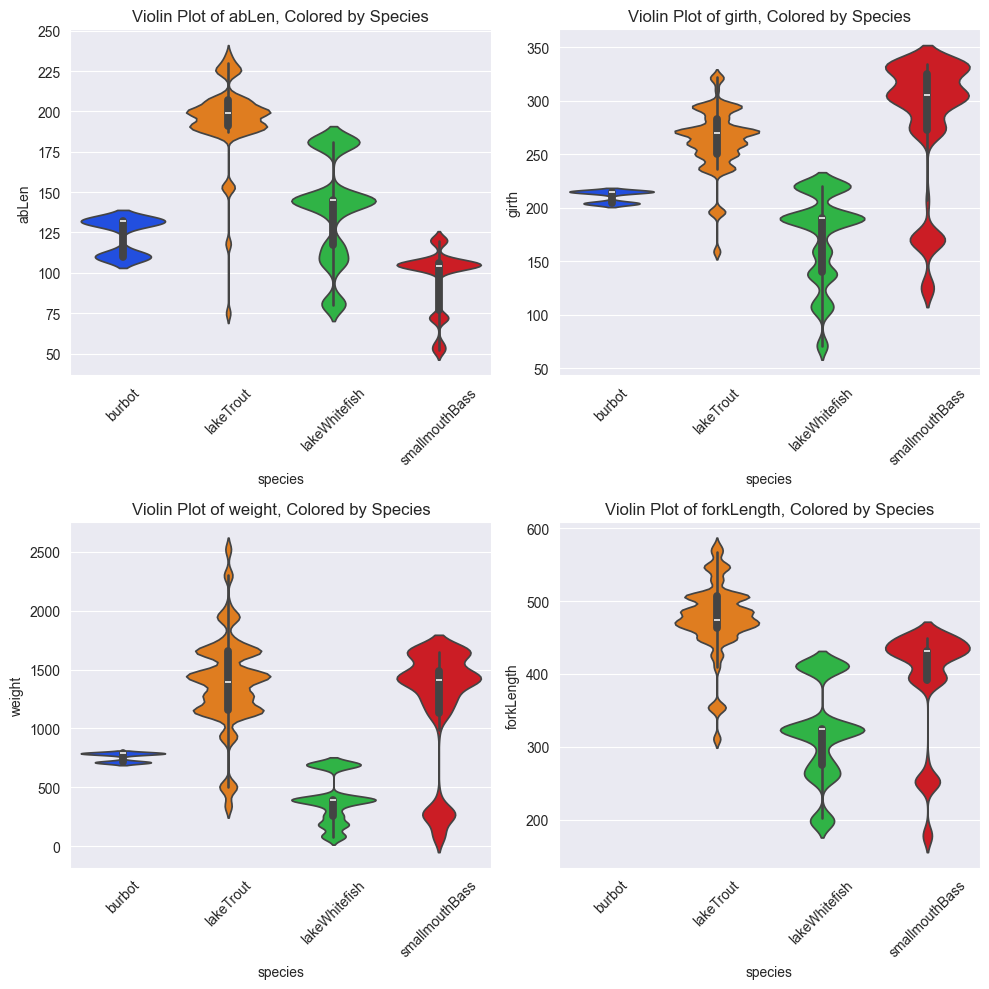

In [141]:
## Save differential geometrics
phyDiff = ["abLen", "girth", "weight", "forkLength"]
f, axes = plt.subplots(2, 2, figsize=(10, 10))  # You can adjust the figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

i = 0
for phyVar in phyDiff:
    sns.violinplot(data=edaPhy, x="species", y=phyVar, ax=axes[i],
                   hue="species",
                   palette="bright")
    axes[i].set_title(f"Violin Plot of {phyVar}, Colored by Species")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
    i += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [166]:
# edaFreqSmry.reset_index(inplace=True)
edaFreqSmryLong = pd.melt(edaFreqSmry, id_vars = ["fishNum", "species"])
edaFreqSmryLong

,fishNum,species,variable,value
0,BUR001,burbot,F45,-46.479146
1,BUR002,burbot,F45,-51.093437
2,LT001,lakeTrout,F45,-46.645407
3,LT002,lakeTrout,F45,-47.560521
4,LT003,lakeTrout,F45,-46.168306
...,...,...,...,...
10330,SMB008,smallmouthBass,F260,-42.592962
10331,SMB009,smallmouthBass,F260,-42.517107
10332,SMB010,smallmouthBass,F260,-39.343412
10333,SMB011,smallmouthBass,F260,-37.988470


In [167]:
edaFreqSmryLong.rename({"variable": "Freq", "value": "TS"}, axis=1, inplace=True)

In [169]:
edaFreqSmryLong["Freq"] = edaFreqSmryLong["Freq"].str.extract(r'(\d+)', expand=False).astype(int)

In [182]:
edaFreqSmryLong.groupby("species").median("TS")

,Freq,TS
species,,
burbot,194.0,-40.157522
lakeTrout,194.0,-44.987537
lakeWhitefish,194.0,-48.487588
smallmouthBass,194.0,-47.837605


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

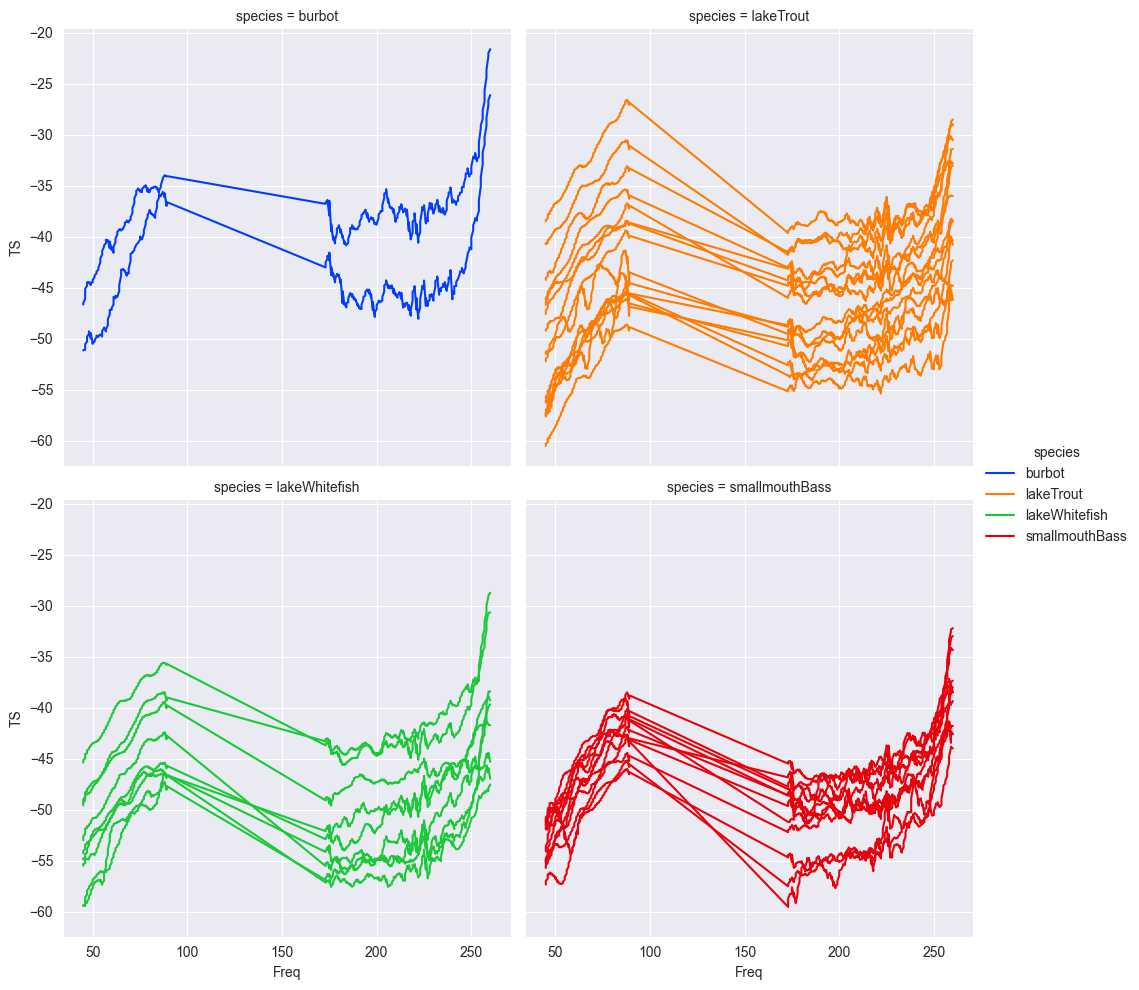

In [179]:
## Spaghetti plot for sonar frequency time
# Per each species, plot their line chart of relationships between TS and frequency, assign error bars.
sns.relplot(edaFreqSmryLong,  kind="line",
            x = "Freq", y="TS", units = "fishNum",
            col = "species", col_wrap = 2, hue = "species",
            palette="bright", estimator=None)
# Add titles and labels
plt.set_title('TS versus frequency by individuals')
plt.xlabel('Freq')
plt.ylabel('TS')
# plt.legend(loc='top')

# Show the plot
plt.show()

# 4. Model Fitting

In [238]:
edaFreqSmry.columns[1:].str.extract(r'(\d+)', expand=False).astype(int)

ValueError: cannot convert float NaN to integer

In [218]:
X = edaFreqSmry.drop(["fishNum", "species"], axis = 1)
X_standardized = StandardScaler().fit(X)
pca = PCA(n_components = X.shape[0], svd_solver = "full")
pca.fit(X)
V2 = pca.components_[:2,] # the first two principle vectors
Z2 = X @ V2.T # The first two score vectors

In [219]:
# The score vector
Z2.rename(columns = {0: "PC1", 1:"PC2"}, inplace = True)
Z2["Species"] = edaFreqSmryLong.species

<Axes: xlabel='None', ylabel='PC1'>

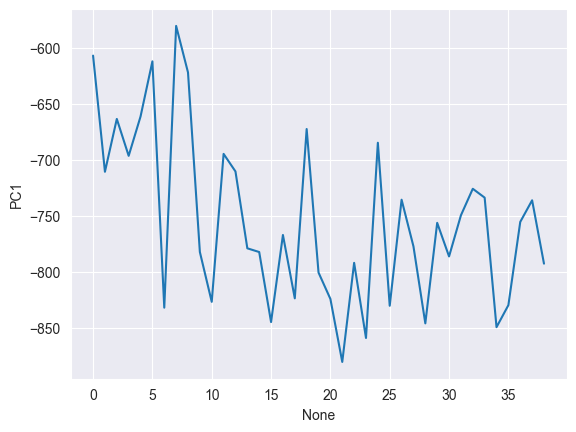

In [221]:
# Z2["Freq"] = edaFreqSmryLong.Freq.unique()
# sns.lineplot(Z2, x = Z2.index, y = "PC1")
sns.lineplot(Z2, x = Z2.index, y = "PC1")
#
# sns.scatterplot(Z2, x = "Freq", y = "PC2")
# Z2.index.str.extract(pat=r'([A-Z]+)').squeeze().tolist()

In [256]:
Z2.head()

,PC1,PC2,Species
0,-607.242774,-22.237837,burbot
1,-710.914910,-0.985653,burbot
2,-663.769301,-20.573217,lakeTrout
3,-696.702452,12.354485,lakeTrout
4,-661.613627,7.348538,lakeTrout


# 5.Plotting

In [249]:
# V2 = V2.T
V2 = pd.DataFrame(V2)
V2["Freq"] = pd.Series(edaFreqSmry.columns[1:]).str.extract(r'(\d+)', expand=False)
V2.head()

,0,1,Freq
0,0.060972,0.090340,45
1,0.060788,0.092053,45
2,0.060987,0.092482,46
3,0.061052,0.092596,46
4,0.060942,0.092979,47


<Figure size 1000x600 with 0 Axes>

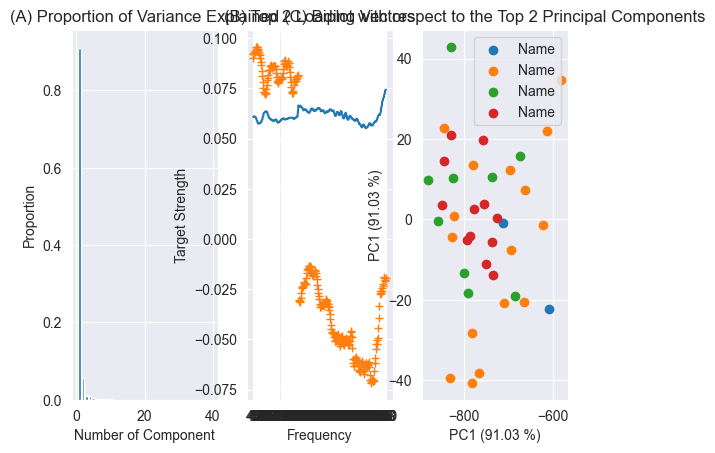

In [275]:
## Scree plot
PVE = pd.DataFrame(pca.explained_variance_ratio_, columns = ["Variance"])
PVE['Component'] = range(1, len(PVE) + 1)  # Adding a component index for plotting

fig = plt.figure(figsize=(10, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

## Scree plot
# ax1 = fig.add_subplot(221)
ax1.bar(PVE.Component, PVE.Variance)
ax1.set_title("(A) Proportion of Variance Explained")
ax1.set_xlabel("Number of Component")
ax1.set_ylabel("Proportion")

## Loading Vectors
# ax2 = fig.add_subplot(222)
ax2.plot(V2["Freq"], V2[0], "-",
         V2["Freq"], V2[1], "+")
ax2.set_title("(B) Top 2 Loading Vectors")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Target Strength")

## Biplot
zGroup  = Z2.groupby('Species')
cmap = dict(zip([burbotPr, lakeTroutPr, lakeWhiteFishPr, smallMouthBassPr],
                plt.cm.tab20.colors[0:5]))

# ax3 = fig.add_subplot(223)
for name, group in zGroup:
    ax3.scatter(group.PC1, group.PC2, label = "Name") ## plt scatter plot by color
plt.legend()
ax3.set_title("(C) Biplot with respect to the Top 2 Principal Components")
ax3.set_xlabel(f"PC1 ({round(PVE.Variance[0]*100, 2)} %)")
ax3.set_ylabel(f"PC1 ({round(PVE.Variance[0]*100, 2)} %)")

plt.show()

C:\Users\86139\AppData\Local\Temp\ipykernel_20264\802801621.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Component', y='Variance', data=PVE[:10], palette='viridis')  # Limiting to the first 10 components


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

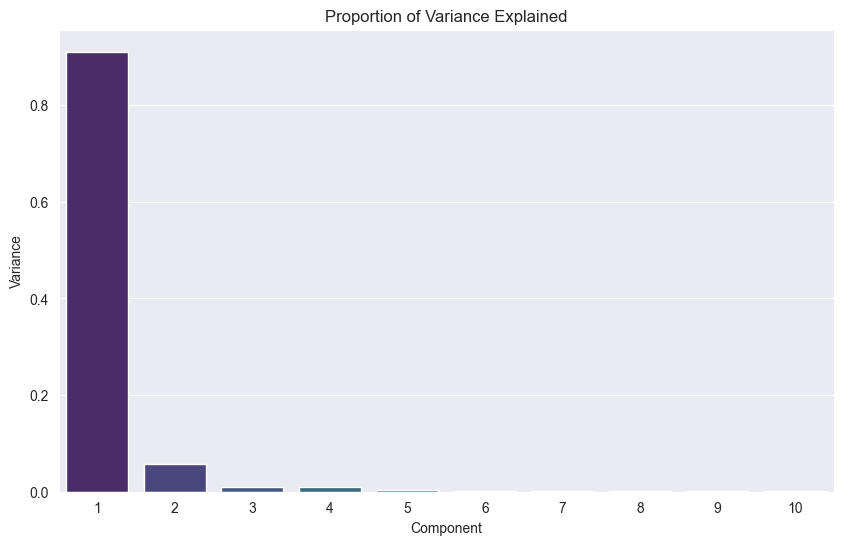

In [194]:
# Creating the scree plot
# fig, ax = plt.subplots()
plt.figure(figsize = (10,6))
sns.barplot(x='Component', y='Variance', data=PVE[:10], palette='viridis')  # Limiting to the first 10 components
plt.title('Proportion of Variance Explained')
plt.set_xlabel('Principal Component')
plt.set_ylabel('Variance')
plt.yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.show()

In [179]:
pveList = pca.explained_variance_ratio_.tolist()

'PC 1 86.02%'

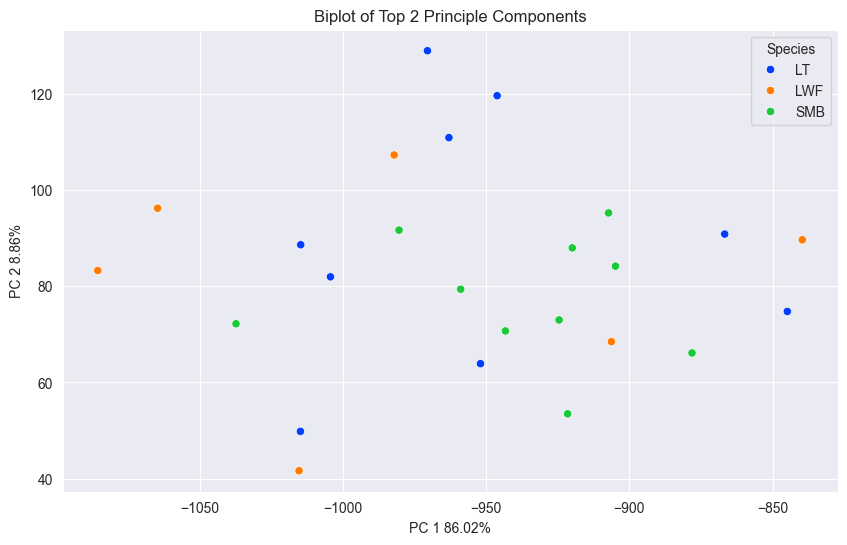

In [181]:
## Create Biplot
plt.figure(figsize = (10,6))
sns.scatterplot(data = Z2, x='PC1', y='PC2', hue = "Species", palette='bright')  # Limiting to the first 10 components
plt.title('Biplot of Top 2 Principle Components')
plt.xlabel(f'PC 1 {pveList[0]*100:.2f}%')
plt.ylabel(f'PC 2 {pveList[1]*100:.2f}%')
plt.show()
# PVE[:10]

In [190]:
# Create Pairplot with marginal distribution histograms
V3 = pca.components_[:3,]
Z3 = X @ V3.T
Z2.rename(columns={0: "PC1", 1: "PC2"}, inplace=True)
Z3["Species"] = Z3.index.str.extract(pat=r'([A-Z]+)').squeeze().tolist()

<Figure size 1000x1000 with 0 Axes>

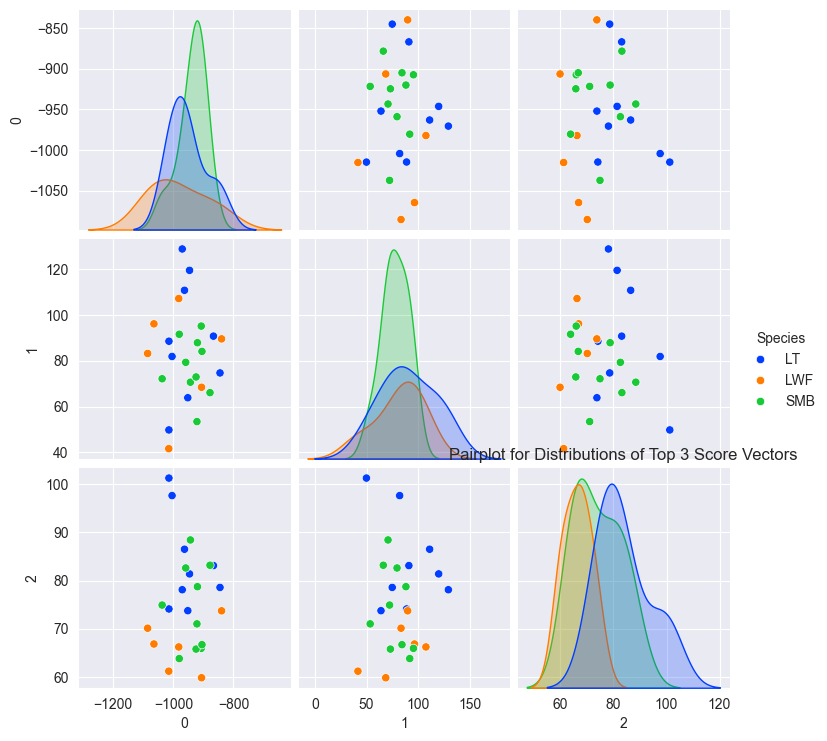

In [191]:
plt.figure(figsize = (10,10))
sns.pairplot(Z3, hue = "Species", palette='bright')
plt.title('Pairplot for Distributions of Top 3 Score Vectors')
plt.show()

In [ ]:
sns.pairplot(Z3, hue = "Species", palette='bright')